### Required Packages

In [1]:
!pip install qiskit qiskit-aer qiskit-machine-learning qiskit-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 643.4/643.4 kB 16.9 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 68.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Importing libraries**

In [2]:
import networkx as nx
import numpy as np
from qiskit_aer import Aer
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_optimization.problems import QuadraticProgram
from qiskit_algorithms import QAOA
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit_machine_learning.algorithms import VQC
from qiskit_algorithms.optimizers import COBYLA

## Testing GPS on Dummy Data STAGE I

In the first portion of the traffic management system, we created a dataset that simulates traffic conditions on a simplified road network of 5 Nodes(which can be used as source or destinations) and the edges between them as roads. Each edge has a traffic level and a maximum road capacity. The key factors we considered include:

* Dummy Traffic Data: For each edge (road), we track the current traffic levels (current_traffic) and maximum road capacity (max_capacity). These values represent real-time congestion, allowing for dynamic updates.
* Dummy Traffic Light States: Each edge is also associated with a traffic light (state), which can be either red or green, introducing delays if a red light is encountered.
This setup allows for simulating real-world traffic conditions and congestion dynamics in the quantum GPS system.

ALGORITHM IMPLEMENTED:

**Quantum GPS Management System**

Based on the dummy traffic dataset and traffic signal( i.e. the next action('red', 'yellow', 'green') to be taken by the traffic signal on vertain intersections) we calculate the most optimal route the vehicle should take based on a custom defined cost function. As soon as the vehicle reaches the next node in its set path it recalculates the path again based on dummy congestion data along the routes available.

In [15]:
import random
import numpy as np
from qiskit import QuantumCircuit, transpile


class MockRoadNetwork:
    def __init__(self):
        self.edges_list = ['A-B', 'A-C', 'B-D', 'C-D', 'D-E', 'A-E', 'B-E', 'C-E']

    def edges(self):
        return self.edges_list

    def get_neighbors(self, node):
        neighbors = {
            'A': ['B', 'C', 'E'],
            'B': ['D', 'E'],
            'C': ['D', 'E'],
            'D': ['E'],
            'E': []
        }
        return neighbors.get(node, [])

class QuantumGPSManagementSystem:
    def __init__(self, road_network, traffic_data, source, destination, traffic_light_data):
        self.road_network = road_network
        self.traffic_data = traffic_data
        self.traffic_light_data = traffic_light_data  # Include traffic lights
        self.source = source
        self.destination = destination
        self.backend = Aer.get_backend('aer_simulator')
        

    def prepare_cost_function(self):
        # Include both traffic and traffic light conditions
        weights = []
        for edge in self.road_network.edges():
            traffic_weight = self.traffic_data[edge]['current_traffic']
            light_state = self.traffic_light_data[edge]['state']
            if light_state == 'red':  # Increase cost for red lights
                light_penalty = 10
            else:
                light_penalty = 0
            weights.append(traffic_weight + light_penalty)
        return np.array(weights)

    def optimize_routes(self):
        num_qubits = len(self.road_network.edges())
        circuit = QuantumCircuit(num_qubits)

        # Create a cost function from current traffic data
        weights = self.prepare_cost_function()

        # Apply QAOA layers
        for i in range(1):  # For p=1
            for j in range(num_qubits):
                if weights[j] > 0:
                    circuit.rzz(2 * weights[j], j, (j + 1) % num_qubits)  # Example cost Hamiltonian
            circuit.h(range(num_qubits))  # Mixing Hamiltonian
        
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, self.backend)
        job = self.backend.run(transpiled_circuit, shots=1024)
        results = job.result()
        counts = results.get_counts(circuit)

        best_route = self.process_results(counts)
        return best_route

    def process_results(self, counts):
        optimal_route = max(counts, key=counts.get)
        edges = self.road_network.edges()
        route_edges = [edges[i] for i in range(len(optimal_route)) if optimal_route[i] == '1']
        return route_edges

    def update_traffic_conditions(self, edge):
        outgoing_traffic = random.randint(0, self.traffic_data[edge]['current_traffic'])
        self.traffic_data[edge]['current_traffic'] -= outgoing_traffic
        
        incoming_traffic = random.randint(0, self.traffic_data[edge]['max_capacity'] - self.traffic_data[edge]['current_traffic'])
        self.traffic_data[edge]['current_traffic'] += incoming_traffic
        
        self.traffic_data[edge]['current_traffic'] = max(0, min(self.traffic_data[edge]['current_traffic'], self.traffic_data[edge]['max_capacity']))
    def update_traffic_lights(self, edge):
        # Mock update logic for traffic lights (can be replaced with real data)
        self.traffic_light_data[edge]['state'] = random.choice(['red', 'green'])
    def simulate_traffic(self):
        for edge in self.road_network.edges():
            self.update_traffic_conditions(edge)
            self.update_traffic_lights(edge)

    def run_simulation(self):
        current_node = self.source
        path_taken = []

        while current_node != self.destination:
            self.simulate_traffic()  
            best_route = self.optimize_routes()
            valid_route = self.get_full_route_to_destination(best_route, current_node)

            if not valid_route:  
                print("No valid route found. Vehicle is stopping.")
                break

            next_edge = valid_route[0]
            path_taken.append(next_edge)
            next_node = next_edge.split('-')[1]
            print(f"Vehicle moving from {current_node} to {next_node} via {next_edge}.")
            
            current_node = next_node

            if current_node == self.destination:
                print(f"Vehicle has reached the destination: {self.destination}.")

        return path_taken

    def get_full_route_to_destination(self, best_route, current_node):
        possible_routes = []

        # Ensure the first edge starts from the current node
        for edge in best_route:
            src, dest = edge.split('-')
            if src == current_node:
                possible_routes.append(edge)

        # If the current node is the source, add a dummy source-starting edge
        if not possible_routes and current_node == self.source:
            possible_routes.append(f"{self.source}-{self.source}")

        neighbors = self.road_network.get_neighbors(current_node)
        for neighbor in neighbors:
            if f'{neighbor}-{self.destination}' in best_route:
                possible_routes.append(f'{neighbor}-{self.destination}')

        return possible_routes


# Initialize the traffic management system
road_network = MockRoadNetwork()
traffic_data = {
    'A-B': {'current_traffic': 2, 'max_capacity': 10},
    'A-C': {'current_traffic': 5, 'max_capacity': 10},
    'B-D': {'current_traffic': 0, 'max_capacity': 10},
    'C-D': {'current_traffic': 5, 'max_capacity': 10},
    'D-E': {'current_traffic': 10, 'max_capacity': 100},
    'A-E': {'current_traffic': 6, 'max_capacity': 10},
    'B-E': {'current_traffic': 9, 'max_capacity': 10},
    'C-E': {'current_traffic': 1, 'max_capacity': 10}
}
traffic_light_data = {
    'A-B': {'state': 'green'},
    'A-C': {'state': 'red'},
    'B-D': {'state': 'green'},
    'C-D': {'state': 'red'},
    'D-E': {'state': 'green'},
    'A-E': {'state': 'red'},
    'B-E': {'state': 'green'},
    'C-E': {'state': 'red'}
}


# Specify source and destination
source = 'A'
destination = 'E'

# Create an instance of the traffic management system
traffic_management_system = QuantumGPSManagementSystem(road_network, traffic_data, source, destination, traffic_light_data)

# Run the simulation
best_route = traffic_management_system.run_simulation()
print(f"The complete path taken by the vehicle is: {best_route}")


Vehicle moving from A to B via A-B.
Vehicle moving from B to D via B-D.
Vehicle moving from D to E via D-E.
Vehicle has reached the destination: E.
The complete path taken by the vehicle is: ['A-B', 'B-D', 'D-E']


## Traffic Signal Optimization

For optimizing the traffic signal so that it reduces the overall wait time while also avoiding congestion, we can train a VQC model and use it to optimize the traffic signal dynamically. This vqc model can be fed in our GPS system to predict the signals next action based on the current traffic conditions thus updating the GPS with the updated optimal route from next node.

**Data Generation**

We used custom algorithm to generate data for efficient model training.
1. Enabling more green light for increased traffic in connected edges.
2. Enabling more green light for incoming emergency traffic.
3. Ensure total minimum wait time to reduce overall congestion.



In [55]:
import numpy as np

# Parameters for data generation
num_samples = 200
max_vehicle_count = 50  # Max number of vehicles on an edge
max_congestion = 1.0  # Congestion as a percentage (0 to 1)

# Generate realistic traffic data
vehicle_counts = np.random.randint(0, max_vehicle_count, size=num_samples)  # Vehicle count between 0 and max_vehicle_count
congestion_levels = np.random.rand(num_samples)  # Congestion levels between 0 and 1
emergency_vehicles = np.random.randint(0, 2, size=num_samples)  # Binary indicator for presence of emergency vehicles

X_train = np.column_stack((vehicle_counts, congestion_levels, emergency_vehicles))

# Generate corresponding signal decision (1 for red, 0 for green)
y_train = []

for i in range(num_samples):
    vehicle_count = vehicle_counts[i]
    congestion = congestion_levels[i]
    emergency_vehicle = emergency_vehicles[i]
    
    # Logic for signal decision:
    if emergency_vehicle == 1:
        # Prioritize green light for emergency vehicles
        y_train.append(0)  # Green light
    elif vehicle_count > max_vehicle_count * 0.7 or congestion > 0.7:
        # If vehicle count or congestion is high, more likely to set red light
        y_train.append(1)  # Red light
    else:
        # Default to green light for low traffic or low congestion
        y_train.append(0)  # Green light

y_train = np.array(y_train)

# Verify the generated data
print("Sample features (vehicle count, congestion, emergency vehicle):")
print(X_train[:5])
print("Sample labels (0 for green, 1 for red):")
print(y_train[:5])


Sample features (vehicle count, congestion, emergency vehicle):
[[ 9.          0.41838394  1.        ]
 [17.          0.21374408  0.        ]
 [ 2.          0.35037465  1.        ]
 [32.          0.49382753  1.        ]
 [43.          0.6868816   0.        ]]
Sample labels (0 for green, 1 for red):
[0 0 0 0 1]


In [4]:
# Preparing the Sampler
from qiskit.primitives import Sampler

sampler = Sampler()

/tmp/ipykernel_30/367537757.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [56]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

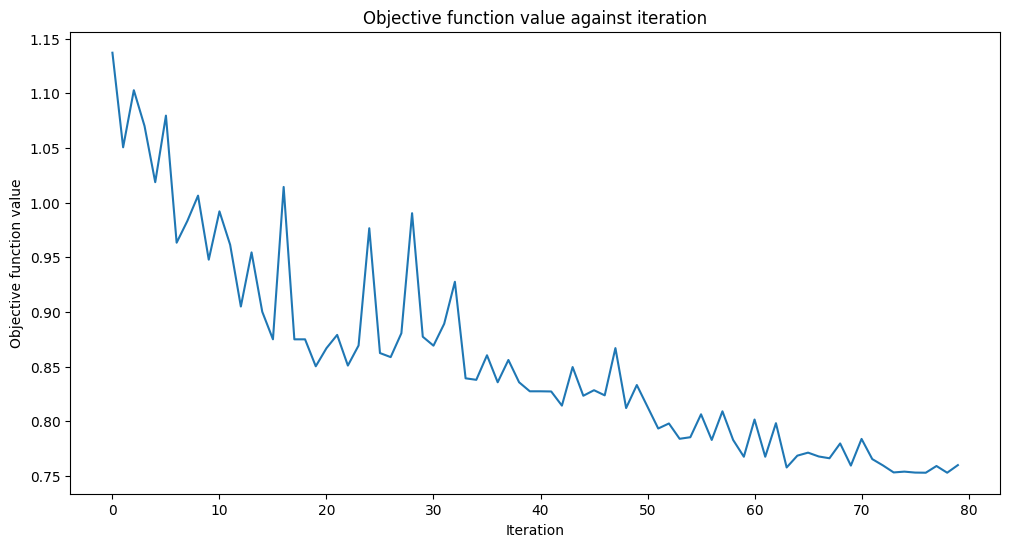

Training time: 165 seconds


In [59]:
# Generate dummy data
import numpy as np
# X_train = np.random.rand(200, 3)  # 100 data points, 3 features (e.g., vehicle count, congestion, number_of_emergency_vehicles)
# y_train = np.random.randint(3, size=200)  # Binary traffic signal decision (e.g., green/red)

# Define feature map and ansatz
feature_map = ZZFeatureMap(feature_dimension=3, reps=4)
ansatz = RealAmplitudes(num_qubits=3, reps=5)

# Initialize VQC
vqc = VQC(sampler=sampler,feature_map=feature_map, ansatz=ansatz, optimizer=COBYLA(maxiter=80),callback=callback_graph,)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [61]:
# Checking the accuracy of the VQC on train dataset
train_score_q4 = vqc.score(X_train, y_train)
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")

Quantum VQC on the training dataset: 0.76


Let's assume some initial state of traffic light data.

This part is just to demonstrate how we would prepare the traffic light data for GPS system after considering the next action of the signal from the VQC model.

In [62]:
class VQCMock:
    def __init__(self, vqc_model):
        self.vqc_model = vqc_model

    def predict(self, data):
        # Use the trained VQC model to predict binary outputs (0 or 1)
        predictions = self.vqc_model.predict(data)
        # Assuming the VQC returns probabilities, convert them to binary (0 or 1)
        binary_predictions = (predictions > 0.5).astype(int)
        return binary_predictions

# # Initialize the actual VQC model
# vqc2 = VQCMock(vqc)  # Pass the trained VQC model

# # Generate dummy traffic data from the road network
# dummy_traffic_data = generate_dummy_traffic_data()

# # Predict the next state of the signals using the actual VQC model
# predicted_signals = vqc.predict(dummy_traffic_data)

# # Update traffic light data based on predictions
# edges = list(traffic_data.keys())
# for i, edge in enumerate(edges):
#     traffic_light_data[edge]['state'] = 'green' if predicted_signals[i] == 1 else 'red'

# # Display the updated traffic light states
# for edge, data in traffic_light_data.items():
#     print(f"Edge {edge}: Next signal state is predicted to be {data['state']}.")


In [98]:
# Prepare traffic light data for GPS system
def prepare_traffic_light_data_for_gps(traffic_light_data):
    formatted_data = {}
    for edge, data in traffic_light_data.items():
        formatted_data[edge] = {
            'state': data['state']  # Directly use the state (e.g., 'green', 'yellow', 'red')
        }
    return formatted_data

# Prepare the formatted traffic light data
formatted_traffic_light_data = prepare_traffic_light_data_for_gps(traffic_light_data)

# Pass the formatted data to the GPS system
traffic_management_system = QuantumGPSManagementSystem(road_network, traffic_data, source, destination, formatted_traffic_light_data)

# Run the simulation with updated traffic light data
best_route = traffic_management_system.run_simulation()
print(f"The complete path taken by the vehicle is: {best_route}")


Vehicle moving from A to C via A-C.
Vehicle moving from C to D via C-D.
Vehicle moving from D to E via D-E.
Vehicle has reached the destination: E.
The complete path taken by the vehicle is: ['A-C', 'C-D', 'D-E']


## Testing GPS on Dummy Data STAGE II
Perfect! Now we can proceed with our GPS system which simulates the feedback loop between the vehicle and the road network.

#### Implementation
1. Initially we have a dummy signal_state(which is the state of the traffic signals). This is the initial state of the GPS system along with some pre-existing congestion along edges.
2. Next we have a GPS system which is a class with all the operations required for the GPS system calculating the most optimal path.
3. The optimal path for all the vehicles are also fed to the signal management system. The signal management system predicts the next action using the pre-trained vqc.
4. This set of next actions is re-fed into the GPS system as soon as it reaches it's next node towards it's destination.

**To include Emergency Vehicle Feature**

1. We need to modify our model to train on 3 features including the number of emergency vehicles on the edges it is controlling.
2. Changing vehicles dataset to include a "emergency_status".
3. Changing the cost function to decrease the "red" light penalty for emergency vehicles.

Below is the implementation of the GPS system showing the optimal paths as it is continuously recalcuated by our suggested algorithm.


In [67]:
import random
import numpy as np
from qiskit import QuantumCircuit, transpile


class MockRoadNetwork:
    def __init__(self):
        self.edges_list = ['A-B', 'A-C', 'B-D', 'C-D', 'D-E', 'A-E', 'B-E', 'C-E']

    def edges(self):
        return self.edges_list

    def get_neighbors(self, node):
        neighbors = {
            'A': ['B', 'C', 'E'],
            'B': ['D', 'E'],
            'C': ['D', 'E'],
            'D': ['E'],
            'E': []
        }
        return neighbors.get(node, [])

class QuantumGPSManagementSystem:
    def __init__(self, road_network, traffic_data, source, destination, traffic_light_data,vqc_model):
        self.road_network = road_network
        self.traffic_data = traffic_data
        self.traffic_light_data = traffic_light_data  # Include traffic lights
        self.source = source
        self.destination = destination
        self.backend = Aer.get_backend('aer_simulator')
        self.vqc_model = vqc_model
        
    def update_congestion(self, edge):
        self.traffic_data[edge]['current_traffic'] += 1
        outgoing_traffic = random.randint(0, self.traffic_data[edge]['current_traffic'])
        self.traffic_data[edge]['current_traffic'] -= outgoing_traffic
        
        incoming_traffic = random.randint(0, self.traffic_data[edge]['max_capacity'] - self.traffic_data[edge]['current_traffic'])
        self.traffic_data[edge]['current_traffic'] += incoming_traffic
        
        self.traffic_data[edge]['current_traffic'] = max(0, min(self.traffic_data[edge]['current_traffic'], self.traffic_data[edge]['max_capacity']))
    def run_vqc_predictions(self):
        # Generate dummy features based on current traffic
        dummy_data = []
        for edge in self.traffic_data:
            current_traffic = self.traffic_data[edge]['current_traffic']
            max_capacity = self.traffic_data[edge]['max_capacity']
            emergency_vehicles=self.traffic_data[edge]['emergency_vehicles']
            dummy_data.append([current_traffic, max_capacity,emergency_vehicles ])
        features=np.array(dummy_data)

        # Use VQC to predict signal states
        predictions = self.vqc_model.predict(features)

        # Update traffic light states based on predictions with random red light chance
        for i, edge in enumerate(self.road_network.edges()):
            new_state = 'red' if predictions[i] == 1 or random.random() < 0.2 else 'green'  # 20% chance to go red
            if self.traffic_light_data[edge]['state'] != new_state:  # Check if the state has changed
                print(f"Traffic light at {edge} updated to {new_state}.")  # Print flag when updated
                self.traffic_light_data[edge]['state'] = new_state  # Update state


            
    def prepare_cost_function(self, is_emergency_vehicle=0):
        """
        Prepare the cost function for traffic flow optimization. 
        For emergency vehicles, reduce the cost for red lights and congestion.
        """
        weights = []
        for edge in self.road_network.edges():
            traffic_weight = self.traffic_data[edge]['current_traffic']
            light_state = self.traffic_light_data[edge]['state']
            
            # Normal vehicle penalty for red lights
            light_penalty = 10 if light_state == 'red' else 0
            
            # Emergency vehicle logic: prioritize by reducing red light and congestion penalty
            if is_emergency_vehicle:
                print("***OPTIMIZING ROUTE FOR EMERGENCY VEHICLE***")
                light_penalty = 2 if light_state == 'red' else 0  # Lower penalty for red light
                traffic_weight = max(0, traffic_weight - 2)  # Reduce traffic impact
                
            # Add the total weight for the edge
            weights.append(traffic_weight + light_penalty)
        
        return np.array(weights)

    def optimize_routes(self,is_emergency_vehicle=0):
        num_qubits = len(self.road_network.edges())
        circuit = QuantumCircuit(num_qubits)

        # Create a cost function from current traffic data
        weights = self.prepare_cost_function(is_emergency_vehicle)

        # Apply QAOA layers
        for i in range(1):  # For p=1
            for j in range(num_qubits):
                if weights[j] > 0:
                    circuit.rzz(2 * weights[j], j, (j + 1) % num_qubits)  # Example cost Hamiltonian
            circuit.h(range(num_qubits))  # Mixing Hamiltonian
        
        circuit.measure_all()
        transpiled_circuit = transpile(circuit, self.backend)
        job = self.backend.run(transpiled_circuit, shots=1024)
        results = job.result()
        counts = results.get_counts(circuit)

        best_route = self.process_results(counts)
        return best_route

    def process_results(self, counts):
        optimal_route = max(counts, key=counts.get)
        edges = self.road_network.edges()
        route_edges = [edges[i] for i in range(len(optimal_route)) if optimal_route[i] == '1']
        return route_edges

    def update_traffic_lights(self, edge):
        # Mock update logic for traffic lights (can be replaced with real data)
        self.traffic_light_data[edge]['state'] = random.choice(['red', 'green'])
    def simulate_traffic(self, vehicles):
        for idx, vehicle in enumerate(vehicles):
            current_node = vehicle['current_node']
            predicted_route = []  # Store the initial predicted route

            print(f"Starting route prediction for Vehicle {idx+1} (from {vehicle['source']} to {vehicle['destination']}):")
            
            while current_node != vehicle['destination']:
                self.run_vqc_predictions()  # Predict new signal states
                best_route = self.optimize_routes(vehicle['emergency_status'])
                valid_route = self.get_full_route_to_destination(best_route, current_node)
                
                if valid_route:
                    next_edge = valid_route[0]
                    predicted_route.append(next_edge)
                    print(f"Vehicle {idx+1} predicted route: {', '.join(predicted_route)}")
                    
                    # Update the vehicle's position and traffic conditions
                    self.update_congestion(next_edge)
                    self.traffic_data[next_edge]['emergency_vehicles']+=vehicle['emergency_status']
                    current_node = next_edge.split('-')[1]
                    vehicle['current_node'] = current_node
                    print(f"Vehicle {idx+1} moves via {next_edge}")
                    
                else:
                    print(f"No valid route for Vehicle {idx+1} at {current_node}. Recalculating route...")
                    predicted_route = []  # Clear route and retry
                    break  # Stop further movement if no valid route is found

            if current_node == vehicle['destination']:
                print(f"Vehicle {idx+1} has reached its destination: {vehicle['destination']}.\n")

    def run_simulation(self):
        current_node = self.source
        path_taken = []

        while current_node != self.destination:
            self.simulate_traffic()  
            best_route = self.optimize_routes()
            valid_route = self.get_full_route_to_destination(best_route, current_node)

            if not valid_route:  
                print("No valid route found. Vehicle is stopping.")
                break

            next_edge = valid_route[0]
            path_taken.append(next_edge)
            next_node = next_edge.split('-')[1]
            print(f"Vehicle moving from {current_node} to {next_node} via {next_edge}.")
            current_node = next_node

            if current_node == self.destination:
                print(f"Vehicle has reached the destination: {self.destination}.")

        return path_taken

    def get_full_route_to_destination(self, best_route, current_node):
        possible_routes = []

        # Ensure the first edge starts from the current node
        for edge in best_route:
            src, dest = edge.split('-')
            if src == current_node:
                possible_routes.append(edge)

        # If the current node is the source, add a dummy source-starting edge
        if not possible_routes and current_node == self.source:
            possible_routes.append(f"{self.source}-{self.source}")

        neighbors = self.road_network.get_neighbors(current_node)
        for neighbor in neighbors:
            if f'{neighbor}-{self.destination}' in best_route:
                possible_routes.append(f'{neighbor}-{self.destination}')

        return possible_routes

def simulate():
    road_network = MockRoadNetwork()
    traffic_data = {
        'A-B': {'current_traffic': 2, 'max_capacity': 10, 'emergency_vehicles': 0, 'number_of_lanes':1},
        'A-C': {'current_traffic': 5, 'max_capacity': 10, 'emergency_vehicles': 0, 'number_of_lanes':2},
        'B-D': {'current_traffic': 0, 'max_capacity': 10, 'emergency_vehicles': 0, 'number_of_lanes':1},
        'C-D': {'current_traffic': 5, 'max_capacity': 20, 'emergency_vehicles': 0,'number_of_lanes':2},
        'D-E': {'current_traffic': 10, 'max_capacity': 40, 'emergency_vehicles': 0, 'number_of_lanes':3},
        'A-E': {'current_traffic': 6, 'max_capacity': 10, 'emergency_vehicles': 0, 'number_of_lanes':1},
        'B-E': {'current_traffic': 9, 'max_capacity': 10, 'emergency_vehicles': 0, 'number_of_lanes':1},
        'C-E': {'current_traffic': 1, 'max_capacity': 20, 'emergency_vehicles': 0, 'number_of_lanes':2}
    }
    traffic_light_data = {
        'A-B': {'state': 'green'},
        'A-C': {'state': 'red'},
        'B-D': {'state': 'green'},
        'C-D': {'state': 'red'},
        'D-E': {'state': 'green'},
        'A-E': {'state': 'red'},
        'B-E': {'state': 'green'},
        'C-E': {'state': 'red'}
    }

    vehicles = [
        {'source': 'A', 'destination': 'E', 'current_node': 'A', 'emergency_status': 0},
        {'source': 'B', 'destination': 'D', 'current_node': 'B', 'emergency_status': 0},
        {'source': 'C', 'destination': 'E', 'current_node': 'C', 'emergency_status': 1},
        {'source': 'D', 'destination': 'E', 'current_node': 'D', 'emergency_status': 0},
        {'source': 'E', 'destination': 'E', 'current_node': 'E', 'emergency_status': 0},
    ]
    vqc1 = VQCMock(vqc)  # Assuming VQC model is already trained
    gps_system = QuantumGPSManagementSystem(road_network, traffic_data, 'A', 'E', traffic_light_data,vqc)
    gps_system.simulate_traffic(vehicles)

simulate()


Starting route prediction for Vehicle 1 (from A to E):
Traffic light at D-E updated to red.
Vehicle 1 predicted route: A-E
Vehicle 1 moves via A-E
Vehicle 1 has reached its destination: E.

Starting route prediction for Vehicle 2 (from B to D):
Traffic light at A-E updated to green.
Vehicle 2 predicted route: B-D
Vehicle 2 moves via B-D
Vehicle 2 has reached its destination: D.

Starting route prediction for Vehicle 3 (from C to E):
Traffic light at A-E updated to red.
***OPTIMIZING ROUTE FOR EMERGENCY VEHICLE***
***OPTIMIZING ROUTE FOR EMERGENCY VEHICLE***
***OPTIMIZING ROUTE FOR EMERGENCY VEHICLE***
***OPTIMIZING ROUTE FOR EMERGENCY VEHICLE***
***OPTIMIZING ROUTE FOR EMERGENCY VEHICLE***
***OPTIMIZING ROUTE FOR EMERGENCY VEHICLE***
***OPTIMIZING ROUTE FOR EMERGENCY VEHICLE***
***OPTIMIZING ROUTE FOR EMERGENCY VEHICLE***
Vehicle 3 predicted route: C-D
Vehicle 3 moves via C-D
Traffic light at A-B updated to red.
Traffic light at C-D updated to green.
Traffic light at A-E updated to gre

In [102]:
!pip freeze>requirements.txt